In [1]:
# Use Python 3.6, networkx 1.11
# Necessary...
import csv # to read CSV file
import networkx as nx # to make and analyze networks/graphs
import unicodedata # to compare strings while ignoring case
import matplotlib.pyplot as plt # to draw figures
from matplotlib.pyplot import figure # to draw figures
from tabulate import tabulate # to display markdown-compatible tables
import operator # to make sorting easier, using .itemgetter
import copy # to make deep copies of lists and such
from copy import deepcopy
import random
import string

In [159]:
# Functions

# Use to ignore case, when searching for occurrences of definiendum and short definiendum in definiens.
def normalize_caseless(text):
    return unicodedata.normalize("NFKD", text.casefold())

# Makes a random 10-item alphanumeric string, to use in node identifiers.
def id_generator(size=10, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

# Checks if node_identifier is already among node_id values in a given network. 
# Returns 0 if not; otherwise, returns number of nodes with that node_id.
def is_unique_node_id(network, node_identifier):
    j = 0
    for i in network.nodes():
        if node_identifier == i: j = j + 1
    return j

# Given a network, an attribute, and a value of attribute, 
# returns node_id of the node, which has that attribute value.
def attribute_value_node_id(network, attribute, value):
    result = None
    for i in nx.get_node_attributes(network, attribute):
        if nx.get_node_attributes(network, attribute)[i] == value: result = i
    if result == None: return 'No node for that attribute value'
    else: return result
    
# Get nodes matching (exactly or approximately) a given attribute value.
# Returns dict, with key = node id, and for each node, a dict with key = your_attribute, and your_attribute_value.
def get_matching_nodes(your_network, your_attribute, your_attribute_value, approximative):
    nodes_to_return = dict() 
    for n in your_network.nodes():
        current_node_attribute_value = nx.get_node_attributes(your_network, your_attribute)[n]
        if (approximative == False and your_attribute_value == current_node_attribute_value) or (approximative == True and your_attribute_value in current_node_attribute_value):
            nodes_to_return[n] = { your_attribute: current_node_attribute_value }
    return nodes_to_return

# Get edges matching (exactly or approximately) a given attribute value.
# Returns dict, with key = edge (origin node id, destination node id), and for each edge, a dict with key = your_attribute, and your_attribute_value.
def get_matching_edges(your_network, your_attribute, your_attribute_value, approximative):
    edges_to_return = dict() # Return dictionary:  key = (origin node id, destination node id), 0th = attribute name, 1st = attribute value.
    for o,d in your_network.edges():
        current_edge_attribute_value = nx.get_edge_attributes(your_network, your_attribute)[o,d]
        if (approximative == False and your_attribute_value == current_edge_attribute_value) or (approximative == True and your_attribute_value in current_edge_attribute_value):
            edges_to_return[o,d] = { your_attribute: current_edge_attribute_value }
    return edges_to_return

# Make a list of randomly made HTML color codes.
# Returns list with as many random colors as number_of_colors.
def make_color_list(number_of_colors):
    color_list = list()
    color_list = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
    return color_list

# Assign a different color to each node.
# Returns dict which appends each item in input dict, with a dict where key = 'color' and value is an HTML color code from color_list.
def color_nodes(node_dict, color_list):
    colored_nodes = dict()
    c = 0
    for n in node_dict:
        colored_nodes[n] = { 'color': color_list[c] }
        c = c + 1
    return colored_nodes

# Assign to an edge the same color as its destination node.
# Returns list of edges, with an HTML color value for each.
def color_edges_by_target_node(edge_dict, edge_colors):
    colored_edges = dict()
    for e in edge_dict:
        for n in edge_colors:
            if e[1] == n: colored_edges[e] = { 'color': edge_colors[n]['color'] }
    return colored_edges


# Set positions of nodes, when drawing Defines relationship instances.
def set_DN_Defines_node_positions(your_network):

    pos = dict()

    x1 = 10
    x2 = -10
    y1 = 0
    y2 = 0

    for o,d in your_network.edges():
        if o not in { attribute_value_node_id(your_network, 'content', 'Definiendum'), attribute_value_node_id(your_network, 'content', 'Definiens') }:
            if nx.get_edge_attributes(your_network, 'relationship')[o,d] == 'Is-a':
                if nx.get_node_attributes(your_network, 'content')[d] == 'Definiendum':
                    y1 = y1 + 1
                    pos[o] = [x1,y1]
                if nx.get_node_attributes(your_network, 'content')[d] == 'Definiens':
                    y2 = y2 + 1
                    pos[o] = [x2,y2]

    pos[attribute_value_node_id(your_network, 'content', 'Definiendum')] = [20, y1/2]
    pos[attribute_value_node_id(your_network, 'content', 'Definiens')] = [-20, y2/2]
    
    return pos

# Draws and makes PNG file of your_network, where:
# - each node is labeled by the value of your_node_label_attribute, 
# - each node is colored according to your_colored_nodes,
# - each edge is colored according to your_colored_edges,
# - PNG file is suffied with filename_suffix.
def draw_subnet(your_network, your_node_label_attribute, your_colored_nodes, your_colored_edges, filename_suffix):
    
    # Let the subgraph be an empty networkx digraph.
    your_subgraph = nx.DiGraph()
    
    # Add nodes
    for i in your_colored_nodes: your_subgraph.add_node(i)
    
    # Make list of node colors
    node_colors_list = list()
    for n in your_colored_nodes: node_colors_list.append(your_colored_nodes[n]['color'])
    
    # Add edges
    for o,d in your_colored_edges: your_subgraph.add_edge(o,d)
    
    # Make list of edge colors
    edge_colors_list = list()
    for o,d in your_colored_edges: edge_colors_list.append(your_colored_edges[o,d]['color'])

    # Make node labels, shorten each label if more than 15 characters long.
    all_node_labels = nx.get_node_attributes(your_network, your_node_label_attribute)
    node_labels_short = dict()
    for n in your_colored_nodes:
        if len(all_node_labels[n]) < 15: node_labels_short[n] = all_node_labels[n]
        else: node_labels_short[n] = all_node_labels[n][0:15] + '...'

    # Draw the subnet
    plt.figure(num=None, figsize=(10, 10), dpi=90, facecolor='w', edgecolor='g')
    pos = nx.spring_layout(your_subgraph, k=20)
    nx.draw(your_subgraph, pos, node_list = your_subgraph.nodes(), edgelist = your_subgraph.edges(), 
            labels = node_labels_short, arrows=True, with_labels=True, 
            node_color = node_colors_list, edge_color = edge_colors_list)

    # Save image as PNG file.
    image_file_name = "%s_Subgraph_%s.png" % (analysis_project_name, filename_suffix)
    plt.savefig(image_file_name)
    print('Sub-network image filename:', image_file_name)

In [3]:
# Set the name of the project, to use as prefix on names of all output files.

## Project: UN Glossary of World Heritage Terms
# analysis_project_name = "UN_GWHT_TDN" 
# analysis_project_data_file = "ilang_UN_GWHT_terminology_raw - Sheet1.csv"

## Project: Smart Retail Network
analysis_project_name = "SRN_DN" 
analysis_project_data_file = "raw_data/ilang_SRN_data.csv"

In [4]:
# Get raw definitions from a CSV file
# Create empty raw_definitions, to hold definiendum, short definiendum (abbreviation of definiens), and definiens.
raw_definitions = []
# Fill raw_definitions as a list of triples, where a triple includes the definiendum, short definiendum, and definiens.
with open(analysis_project_data_file) as raw_definitions_file:
    raw_definitions_csv = csv.reader(raw_definitions_file, delimiter = ',')
    for row in raw_definitions_csv:
        raw_definitions.append({'definiendum':row[0], 'short definiendum':row[1], 'definiens':row[2]})

In [5]:
# Remove the column title row from raw_definitions.
raw_defs = [(raw_definitions[i]) for i in range(1,len(raw_definitions))]

In [6]:
### Definition Network

# Make an empty Definition Network.
dn = nx.DiGraph()

## Populate Definition Network with nodes.
# Make 2*len(raw_defs)+2 nodes, give each a unique node_id (unique in the given network only).
# node_id has format node_[random 8 characters].
for i in range(0, 2*len(raw_defs)+2):
    node_id = analysis_project_name + '_node_' + id_generator()
    if is_unique_node_id(dn, node_id) == 0:
        dn.add_node(node_id)

In [7]:
## Label all Definition Network nodes.
# Put definientia, definienda, Definiendum, and Definiens node labels in a list.
node_content_list = list()
[ node_content_list.append(raw_defs[i][j]) for j in { 'definiendum', 'definiens' } for i in range(0, len(raw_defs))]
node_content_list.append('Definiendum')
node_content_list.append('Definiens')

# Make a dictionary of (node_id, node content value) pairs.
node_content_dict = dict()
for i in range(0, len(dn.nodes())):
    node_content_dict[list(dn.nodes())[i]] = node_content_list[i]

# Set node 'content' attribute using node_content_dict.
nx.set_node_attributes(dn, name = 'content', values = node_content_dict)

In [8]:
## Populate network with Is-a relationship edges.
for i in dn.nodes():
    for j in range(0, len(raw_defs)):
        if raw_defs[j]['definiens'] == nx.get_node_attributes(dn, 'content')[i]:
            dn.add_edge(i, attribute_value_node_id(dn, 'content', 'Definiens'), relationship = 'Is-a')
        if raw_defs[j]['definiendum'] == nx.get_node_attributes(dn, 'content')[i]:
            dn.add_edge(i, attribute_value_node_id(dn, 'content', 'Definiendum'), relationship = 'Is-a')

In [9]:
## Populate network with Defines relationship edges.
for i in range(0, len(raw_defs)):
        dn.add_edge(attribute_value_node_id(dn, 'content', raw_defs[i]['definiens']), attribute_value_node_id(dn, 'content', raw_defs[i]['definiendum']), relationship = 'Defines')    

Sub-network image filename: SRN_DN_Subgraph_Is-a.png


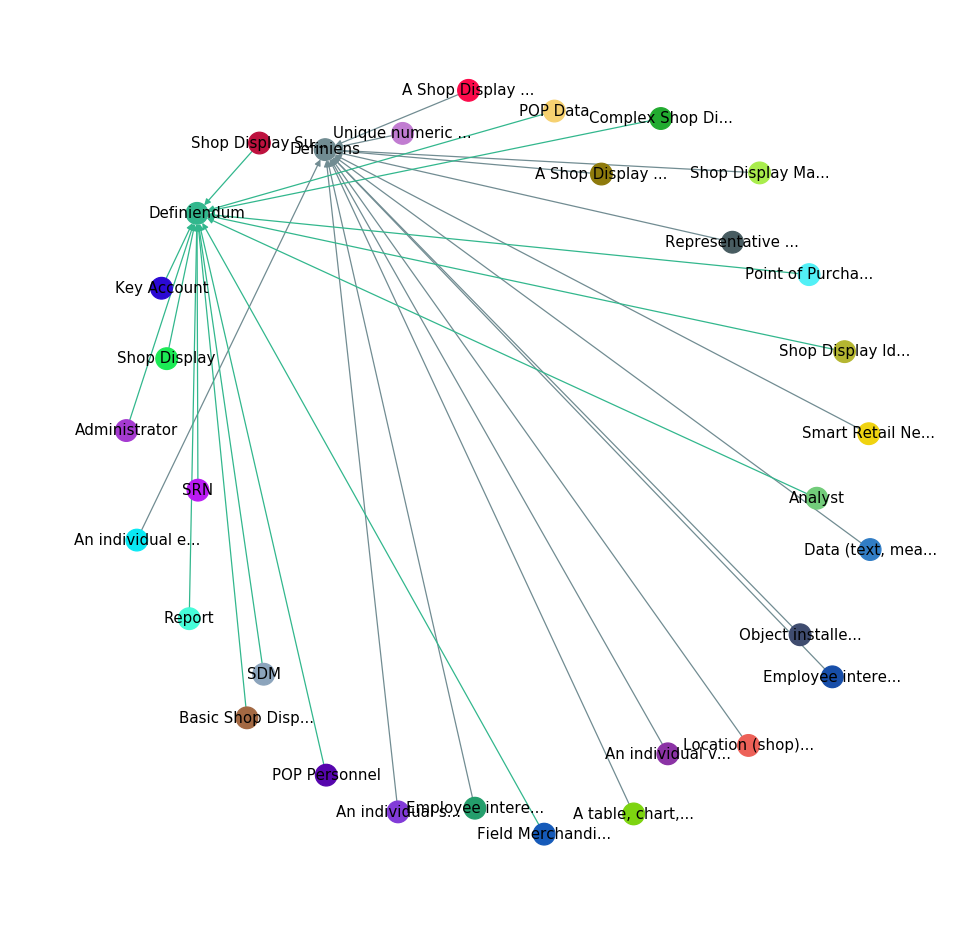

In [160]:
# Draw Is-a subnet
my_node_colors = color_nodes(dn.nodes(), make_color_list(len(dn.nodes())))
my_edges = get_matching_edges(dn, 'relationship', 'Is-a', False)
my_edge_colors = color_edges_by_target_node(my_edges, my_node_colors)
draw_subnet(dn, 'content', my_node_colors, my_edge_colors, 'Is-a')

Sub-network image filename: SRN_DN_Subgraph_Defines.png


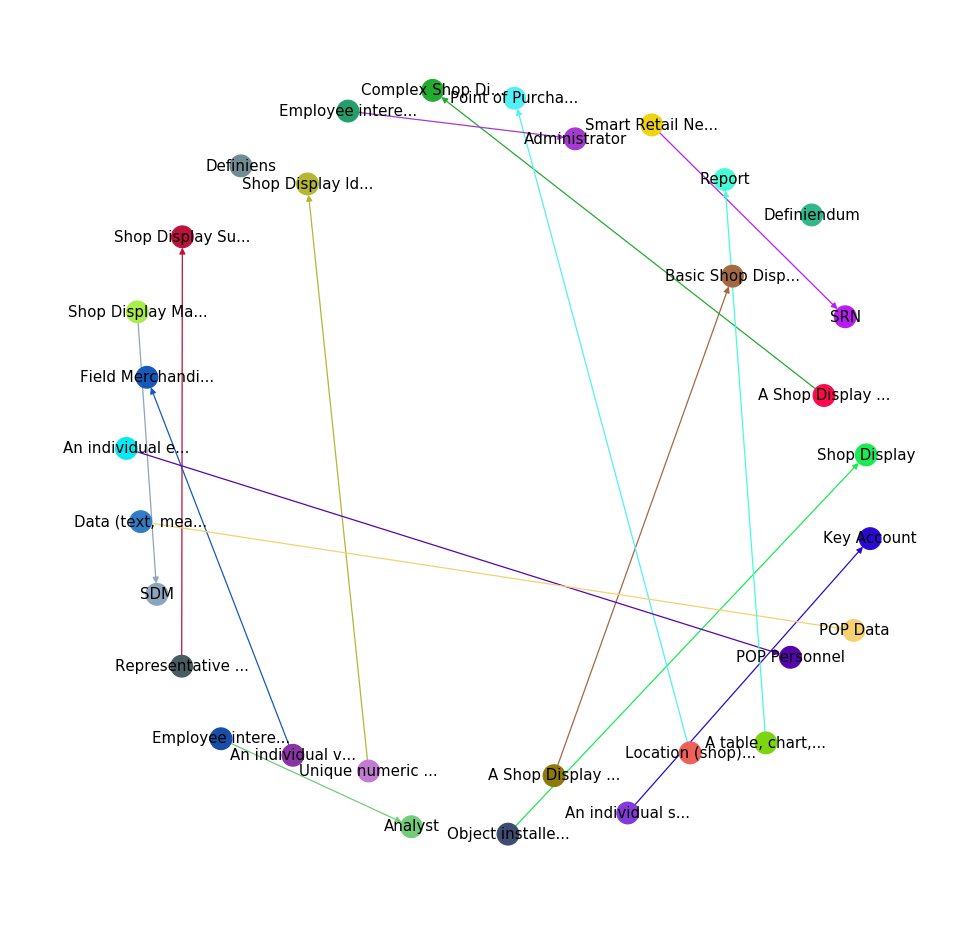

In [161]:
# Draw Defines subnet
# my_node_colors = color_nodes(dn.nodes(), make_color_list(len(dn.nodes())))
my_edges = get_matching_edges(dn, 'relationship', 'Defines', False)
my_edge_colors = color_edges_by_target_node(my_edges, my_node_colors)
draw_subnet(dn, 'content', my_node_colors, my_edge_colors, 'Defines')

In [53]:
pos = nx.spring_layout(dn, k=20)

In [54]:
pos

{'SRN_DN_node_WI312URDWX': array([ 0.31343302, -0.9192555 ]),
 'SRN_DN_node_CPQ1O4NXS7': array([ 0.81684997, -0.10021875]),
 'SRN_DN_node_WAZJ1EFIDD': array([-0.42153344,  0.78468013]),
 'SRN_DN_node_MJVDORLN70': array([0.03987354, 1.        ]),
 'SRN_DN_node_NPQ7UAA6QP': array([-0.6271639 , -0.78734178]),
 'SRN_DN_node_NJYZ8ENUVT': array([-0.03506054,  0.85459584]),
 'SRN_DN_node_7LUD9GEQBC': array([0.75744279, 0.65357791]),
 'SRN_DN_node_TAICB1DAVC': array([-0.81876629,  0.41888892]),
 'SRN_DN_node_92KY1CR2X6': array([-0.76005536, -0.61428065]),
 'SRN_DN_node_ZNXIM0A6GE': array([0.25979631, 0.88709922]),
 'SRN_DN_node_FQWMGDCNJ6': array([0.86383917, 0.26253623]),
 'SRN_DN_node_NA9LP54X2M': array([-0.26561122, -0.87328054]),
 'SRN_DN_node_U39BXJ31WD': array([-0.79338933, -0.28899963]),
 'SRN_DN_node_Z4R5OJ3FCD': array([-0.89805892, -0.41710711]),
 'SRN_DN_node_OPV2C9JYEY': array([0.45521826, 0.91215096]),
 'SRN_DN_node_KDWG4LIAOG': array([0.96482561, 0.07804093]),
 'SRN_DN_node_RCBNSG

In [89]:
nx.get_node_attributes(dn, 'content')['SRN_DN_node_WI312URDWX']

'Smart Retail Network software.'

In [149]:
# Set positions of nodes, when drawing Defines relationship instances.
def set_DN_Defines_node_positions(your_network):

    pos = dict()

    x1 = 10
    x2 = -10
    y1 = 0
    y2 = 0

    for o,d in dn.edges():
        if o not in { attribute_value_node_id(your_network, 'content', 'Definiendum'), attribute_value_node_id(dn, 'content', 'Definiens') }:
            if nx.get_edge_attributes(your_network, 'relationship')[o,d] == 'Is-a':
                if nx.get_node_attributes(your_network, 'content')[d] == 'Definiendum':
                    y1 = y1 + 1
                    pos[o] = [x1,y1]
                if nx.get_node_attributes(your_network, 'content')[d] == 'Definiens':
                    y2 = y2 + 1
                    pos[o] = [x2,y2]

    pos[attribute_value_node_id(your_network, 'content', 'Definiendum')] = [20, y1/2]
    pos[attribute_value_node_id(your_network, 'content', 'Definiens')] = [-20, y2/2]
    
    return pos

In [151]:
pos = set_DN_Defines_node_positions(dn)

In [152]:
pos

{'SRN_DN_node_WI312URDWX': [-10, 1],
 'SRN_DN_node_CPQ1O4NXS7': [-10, 2],
 'SRN_DN_node_WAZJ1EFIDD': [-10, 3],
 'SRN_DN_node_MJVDORLN70': [-10, 4],
 'SRN_DN_node_NPQ7UAA6QP': [-10, 5],
 'SRN_DN_node_NJYZ8ENUVT': [-10, 6],
 'SRN_DN_node_7LUD9GEQBC': [-10, 7],
 'SRN_DN_node_TAICB1DAVC': [-10, 8],
 'SRN_DN_node_92KY1CR2X6': [-10, 9],
 'SRN_DN_node_ZNXIM0A6GE': [-10, 10],
 'SRN_DN_node_FQWMGDCNJ6': [-10, 11],
 'SRN_DN_node_NA9LP54X2M': [-10, 12],
 'SRN_DN_node_U39BXJ31WD': [-10, 13],
 'SRN_DN_node_Z4R5OJ3FCD': [-10, 14],
 'SRN_DN_node_OPV2C9JYEY': [-10, 15],
 'SRN_DN_node_KDWG4LIAOG': [10, 1],
 'SRN_DN_node_RCBNSGUE2W': [10, 2],
 'SRN_DN_node_VWYL5XP67O': [10, 3],
 'SRN_DN_node_8W5YBPMF5N': [10, 4],
 'SRN_DN_node_TKOZB4CZBJ': [10, 5],
 'SRN_DN_node_O2L88W1AZA': [10, 6],
 'SRN_DN_node_WZ4GBZJJKB': [10, 7],
 'SRN_DN_node_FNLFFM7FJZ': [10, 8],
 'SRN_DN_node_8QOUCFLJLZ': [10, 9],
 'SRN_DN_node_Q5BQDGUTWF': [10, 10],
 'SRN_DN_node_ZWJNP9P9R9': [10, 11],
 'SRN_DN_node_9JZCI7B9IC': [10, 12],
 'SR

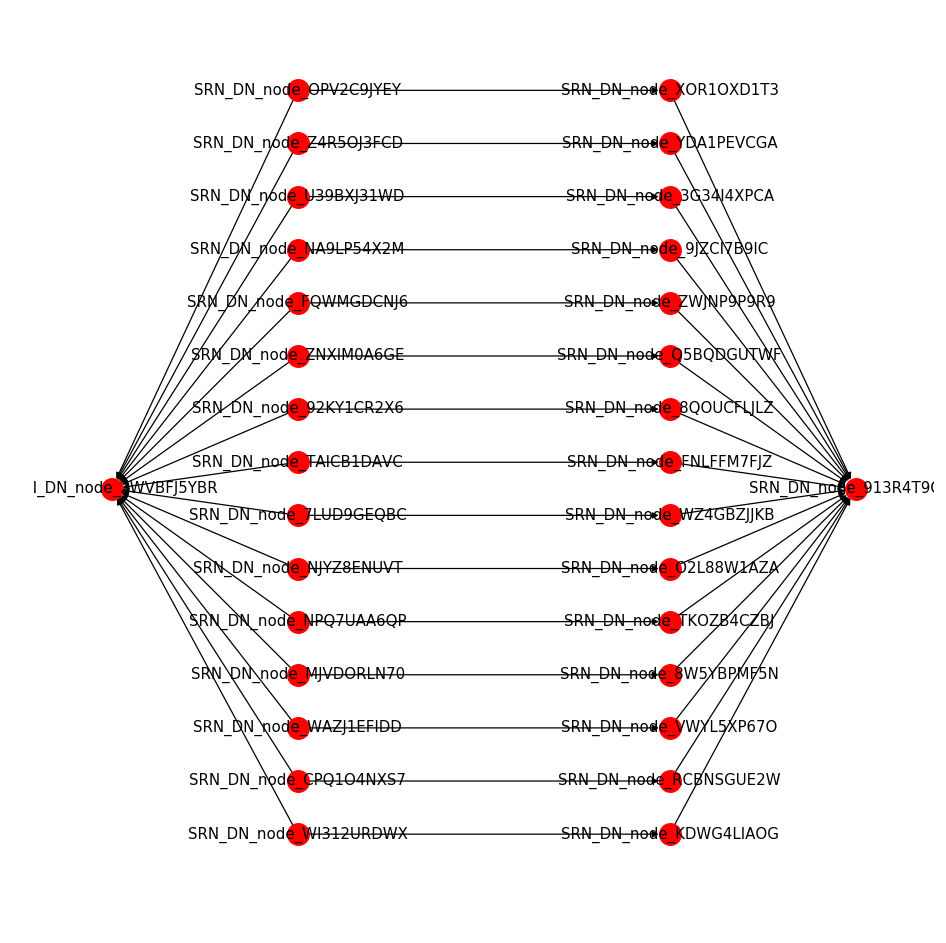

In [153]:
plt.figure(num=None, figsize=(10, 10), dpi=90, facecolor='w', edgecolor='g')
nx.draw(dn, pos, arrows=True, with_labels=True)

In [325]:
edges_to_show = get_matching_edges(dn, 'relationship', 'Defines', False)

In [330]:
nodes_to_show = dict()
for n in dn.nodes():
    nodes_to_show[n] = { 'content': nx.get_node_attributes(dn, 'content')[n] }

In [334]:
node_color_list = make_color_list(len(nodes_to_show))

In [336]:
node_colors = color_nodes(nodes_to_show, node_color_list)

In [340]:
edge_colors = color_edges_by_target_node(edges_to_show, node_colors)

In [343]:
node_pos = set_DN_Defines_node_positions(dn)

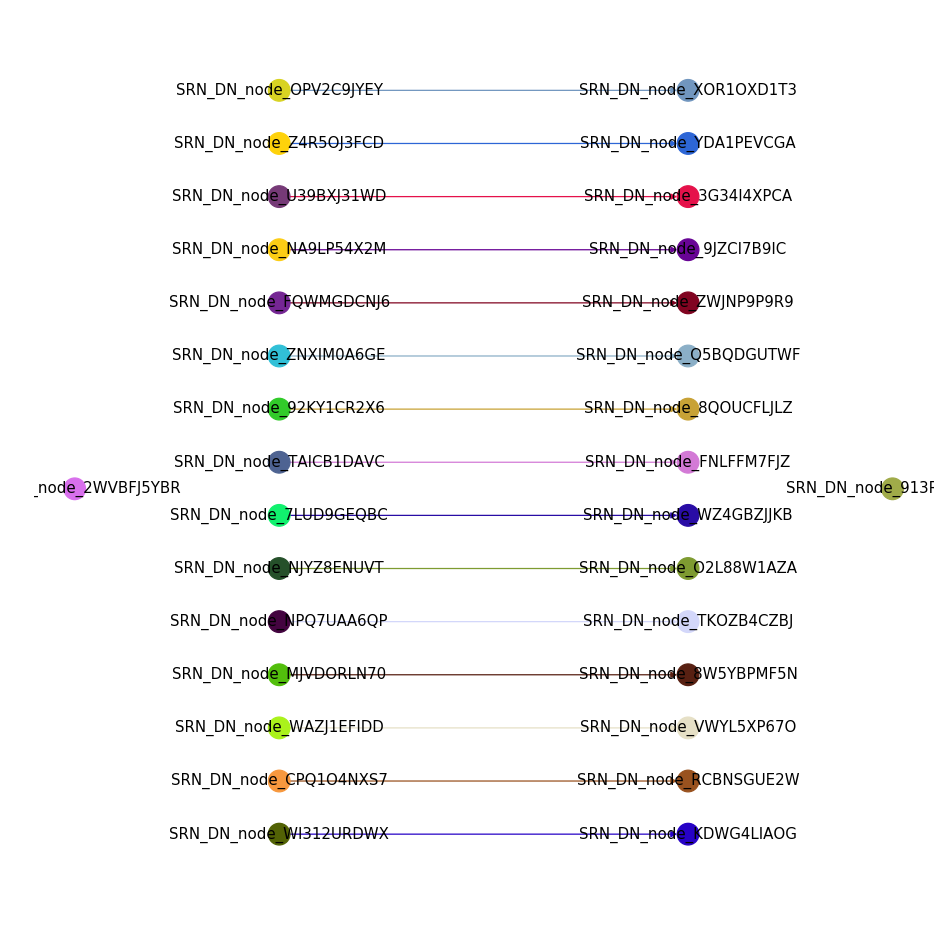

In [366]:
n_colors = list() 
for n in node_colors: n_colors.append(node_colors[n]['color'])
e_colors = list() 
for e in edge_colors: e_colors.append(edge_colors[e]['color'])

# Draw the subnet
plt.figure(num=None, figsize=(10, 10), dpi=90, facecolor='w', edgecolor='g')
nx.draw(dn, node_pos, node_list = nodes_to_show, edgelist = edges_to_show, arrows=True, with_labels=True, node_color = n_colors, edge_color = e_colors)
# nx.draw(dn, node_list = nodes_to_show, edgelist = edges_to_show, arrows=True, with_labels=True, node_color = node_colors, edge_color = edge_colors)

# # Save image as PNG file.
# image_file_name = "%s_Subgraph_%s.png" % (analysis_project_name, filename_suffix)
# plt.savefig(image_file_name)
# print('Sub-network image filename:', image_file_name)